In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import pickle
import torch

In [2]:
data = load_data('../../data/vehicle_claims/vehicle_claims_labeled.csv')

In [62]:
with open('../model/som_vehicle_claims_label_encode_5_True', 'rb') as infile:
    som = pickle.load(infile)

In [4]:
som.get_weights().shape

(25, 25, 208)

In [5]:
from fastai.layers import Embedding
from fastai.torch_core import Module
from typing import List, Tuple
import torch.nn as nn
import torch

In [6]:
class EmbeddingLayer(Module):

    def __init__(self, emb_szs: List[Tuple[int, int]]):
        self.embeddings = torch.nn.ModuleList([Embedding(in_sz, out_sz) for in_sz, out_sz in emb_szs])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = [emb(x[..., i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, dim=-1)
        return x

In [7]:
categorical_cols = ['Maker','Reg_year', ' Genmodel', 'Color', 'Bodytype', 'Engin_size', 'Gearbox', 'Fuel_type',
                        'Seat_num', 'Door_num', 'issue', 'issue_id', 'repair_complexity']

In [8]:
cat_cols = data[categorical_cols].astype("category")

In [9]:
embedded_cols = {n: len(col.cat.categories) for n,col in cat_cols.items() if (col.dtype == "category")}
embedded_cols

{'Maker': 88,
 'Reg_year': 27,
 ' Genmodel': 896,
 'Color': 23,
 'Bodytype': 19,
 'Engin_size': 75,
 'Gearbox': 4,
 'Fuel_type': 14,
 'Seat_num': 20,
 'Door_num': 7,
 'issue': 15,
 'issue_id': 6,
 'repair_complexity': 4}

In [10]:
embedded_col_names = embedded_cols.keys()
embed = []
for i, name in enumerate(embedded_col_names):
    embed_elem = {cat : n for n, cat in enumerate(cat_cols[name].cat.categories)}
    embed.append(embed_elem)

In [11]:
embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]
embedding_sizes

[(88, 44),
 (27, 14),
 (896, 50),
 (23, 12),
 (19, 10),
 (75, 38),
 (4, 2),
 (14, 7),
 (20, 10),
 (7, 4),
 (15, 8),
 (6, 3),
 (4, 2)]

In [12]:
sum = 0
for i in range(len(embedding_sizes)):
    sum = sum + embedding_sizes[i][1]
print(sum)

204


In [13]:
weights = som.get_weights()

In [14]:
weights.shape

(25, 25, 208)

In [15]:
embedding_weights = {}
start = 0
end = 0
for i in range(len(embedding_sizes)):
    end = start + embedding_sizes[i][1]
    print(start, end)
    embedding_weights[i] = weights[:,:,start:end]
    start = end 
    

0 44
44 58
58 108
108 120
120 130
130 168
168 170
170 177
177 187
187 191
191 199
199 202
202 204


In [16]:
with open('../../emb_weights.npy', 'rb') as f:
    w = np.load(f, allow_pickle=True)

In [17]:
test_data = load_data('../../data/vehicle_claims/test.csv')

In [18]:
cd ..

C:\Users\ajayc\Desktop\ajay_chawda\Code


In [19]:
from datasets.vehicle_claims import Vehicle_Claims

In [60]:
test_path = '../data/vehicle_claims/test.csv'
test_label_file = 'test_Y.csv'
test_dataset = Vehicle_Claims(embedding_layer = True,  encoding = False,  path = test_path, label_file = test_label_file)

In [21]:
from torch.utils.data import DataLoader
from classic_ML.SOM import som_train, som_pred, som_embedding_data

In [64]:
dataloader = DataLoader(test_dataset, batch_size = 1024)
frequencies = np.zeros((5,5))
w_x, w_y = [], []
for i, data in enumerate(dataloader):
    print(i)
    y_test = np.hstack((y_test, data[2]))
    data = som_embedding_data(data[0], data[1], test_dataset.embedding_sizes)
    data = data.detach()
    pred = som_pred(som, data, (100-70)/100)
    y_pred = np.hstack((y_pred, pred))
    x, y = zip(*[som.winner(d) for d in data])
    w_x = np.hstack((w_x,x))
    w_y = np.hstack((w_y,y))
    a = som.activation_response(data)
    frequencies = np.add(frequencies, a)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [65]:
w_x = np.array(w_x)
w_y = np.array(w_y)

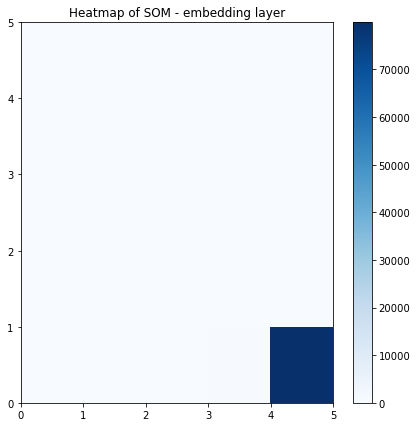

In [66]:
plt.figure(figsize=(7, 7))
plt.title('Heatmap of SOM - embedding layer')
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.savefig('SOM_embed_VC_5.png')


In [28]:
test_path = '../data/vehicle_claims/test_label.csv'
test_label_file = 'test_label_Y.csv'
test_dataset = Vehicle_Claims(embedding_layer = False,  encoding = "label_encode",  path = test_path, label_file = test_label_file)

In [31]:
with open('../model/som_vehicle_claims_label_encode_5_False', 'rb') as infile:
    som = pickle.load(infile)

In [41]:
dataloader = DataLoader(test_dataset, batch_size = 1024)
frequencies = np.zeros((25,25))
w_x, w_y = [], []
for i, data in enumerate(dataloader):
    print(i)
    y_test = np.hstack((y_test, data[2]))
    data = torch.cat([data[0], data[1]], -1)
    data = data.detach()
    pred = som_pred(som, data, (100-70)/100)
    y_pred = np.hstack((y_pred, pred))
    x, y = zip(*[som.winner(d) for d in data])
    w_x = np.hstack((w_x,x))
    w_y = np.hstack((w_y,y))
    a = som.activation_response(data)
    frequencies = np.add(frequencies, a)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


In [42]:
w_x = np.array(w_x)
w_y = np.array(w_y)

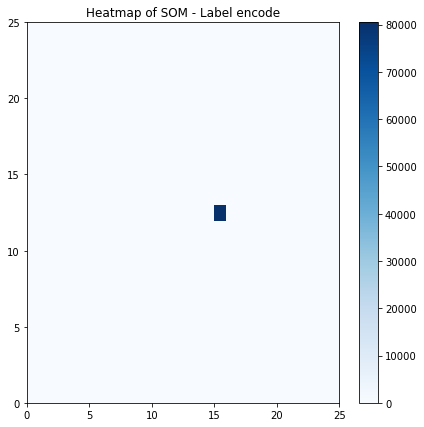

In [43]:
plt.figure(figsize=(7, 7))
plt.title('Heatmap of SOM - Label encode')
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.savefig('SOM_label_heatmap.png')

In [67]:
from datasets.vehicle_insurance import Vehicle_Insurance
test_path = '../data/vehicle_insurance/test.csv'
test_label_file = 'test_Y.csv'
test_dataset = Vehicle_Insurance(embedding_layer = True,  encoding = False,  path = test_path, label_file = test_label_file)

In [68]:
with open('../model/som_vehicle_insurance_label_encode_5_True', 'rb') as infile:
    som = pickle.load(infile)

In [69]:
dataloader = DataLoader(test_dataset, batch_size = 1024)
frequencies = np.zeros((5,5))
w_x, w_y = [], []
for i, data in enumerate(dataloader):
    print(i)
    y_test = np.hstack((y_test, data[2]))
    data = som_embedding_data(data[0], data[1], test_dataset.embedding_sizes)
    data = data.detach()
    pred = som_pred(som, data, (100-70)/100)
    y_pred = np.hstack((y_pred, pred))
    x, y = zip(*[som.winner(d) for d in data])
    w_x = np.hstack((w_x,x))
    w_y = np.hstack((w_y,y))
    a = som.activation_response(data)
    frequencies = np.add(frequencies, a)

0
1
2
3
4


In [70]:
w_x = np.array(w_x)
w_y = np.array(w_y)

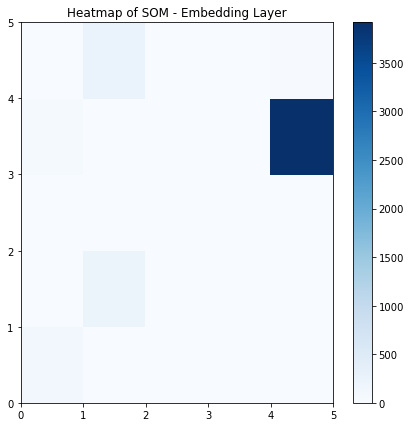

In [71]:
plt.figure(figsize=(7, 7))
plt.title('Heatmap of SOM - Embedding Layer')
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.savefig('SOM_embed_VI_5.png')

In [72]:
from datasets.car_insurance import Car_insurance
test_path = '../data/car_insurance/test.csv'
test_label_file = 'test_Y.csv'
test_dataset = Car_insurance(embedding_layer = True,  encoding = False,  path = test_path, label_file = test_label_file)

In [73]:
with open('../model/som_car_insurance_label_encode_5_True', 'rb') as infile:
    som = pickle.load(infile)

In [74]:
dataloader = DataLoader(test_dataset, batch_size = 1024)
frequencies = np.zeros((5,5))
w_x, w_y = [], []
for i, data in enumerate(dataloader):
    print(i)
    y_test = np.hstack((y_test, data[2]))
    data = som_embedding_data(data[0], data[1], test_dataset.embedding_sizes)
    data = data.detach()
    pred = som_pred(som, data, (100-70)/100)
    y_pred = np.hstack((y_pred, pred))
    x, y = zip(*[som.winner(d) for d in data])
    w_x = np.hstack((w_x,x))
    w_y = np.hstack((w_y,y))
    a = som.activation_response(data)
    frequencies = np.add(frequencies, a)

0


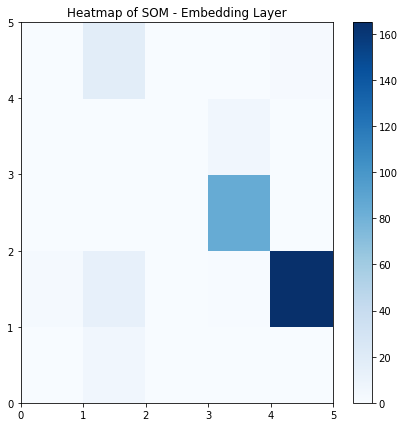

In [75]:
w_x = np.array(w_x)
w_y = np.array(w_y)
plt.figure(figsize=(7, 7))
plt.title('Heatmap of SOM - Embedding Layer')
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.savefig('SOM_embed_CI_5.png')